In [1]:
import os
from pathlib import Path
from pydantic import BaseSettings
from matplotlib import  pyplot as plt

import numpy as np
from tqdm import tqdm
from scipy.stats import iqr
from torch.utils.data import DataLoader

In [2]:
class StatsConfig(BaseSettings):
    class Config:
        env_file = ".env"
        env_file_encoding = "utf-8"
    data_processed: Path
    subset: str = "train"

In [3]:
cwd = Path(os.getcwd())
os.chdir(str(cwd.parent))
print(os.getcwd())

/home/arnaudo/links/shelter/flood-segmentation


In [4]:
cfg = StatsConfig()
cfg

StatsConfig(data_processed=PosixPath('/mnt/userdata/arnaudo_data/flood-delineation'), subset='train')

In [61]:
import importlib
from floods.datasets import flood
from floods import prepare

importlib.reload(flood)
importlib.reload(prepare)


<module 'floods.prepare' from '/home/arnaudo/links/shelter/flood-segmentation/floods/prepare.py'>

In [6]:
dataset = flood.FloodDataset(path=cfg.data_processed, subset="train", include_dem=True, transform=None)
loader = DataLoader(dataset, batch_size=64, num_workers=4, pin_memory=True, shuffle=False)

In [ ]:

# Measure the percentile intervals and then estimate Standard Deviation of the distribution, both from median to the 90th percentile and from the 10th to 90th percentile
p25s = list()
p75s = list()
p50s = list()
minval = np.ones(3) * np.finfo(np.float32).max
maxval = np.ones(3) * np.finfo(np.float32).min


# compute a robust standard deviation using 10th and 90th percentile
for image, label in tqdm(loader):
    image = image.numpy().reshape(-1, 3)
    valid = label.flatten() != 255
    image = image[valid]
    minval = np.minimum(minval, np.min(image, axis=0))
    maxval = np.maximum(maxval, np.max(image, axis=0))

    p75, p25 = np.percentile(image, (75, 25), axis=0)
    p25s.append(p25)
    p75s.append(p75)
    p50s.append(np.median(image, axis=0))

p25 = np.stack(p25s).mean(axis=0)
p75 = np.stack(p75s).mean(axis=0)
p50 = np.stack(p50s).mean(axis=0)

iqr = p75 - p25
sigma = iqr / 1.34896

In [ ]:
print(f"std: {sigma}")
print(f"median: {p50}")
print(f"min: {[f'{v:.4f}' for v in minval]}")
print(f"max: {[f'{v:.4f}' for v in maxval]}")

In [ ]:
factor = 3

clip_min = p50 - factor * sigma
clip_max = p50 + factor * sigma
# store values
means = list()
stds = list()
# compute robust mean and std on data outside (factor x) iqr
for image, label in tqdm(loader):
    image = image.reshape(-1, 3)
    valid = label.flatten() != 255
    image = image[valid]

    image = np.clip(image, clip_min, clip_max)
    means.append(image.mean(axis=0))
    stds.append(image.std(axis=0))

means = np.stack(means).mean(axis=0)
stds = np.stack(stds).mean(axis=0)
print(f"avg: {means}")
print(f"std: {stds}")


In [6]:
means = np.array([0.78545432, 0.64048047, 125.11261959])
stds = np.array([0.08895176, 0.09434253, 50.87297257])

In [62]:
dataset_cls = flood.FloodDataset
transform = prepare.eval_transforms(mean=dataset_cls.mean(), std=dataset_cls.std(), clip_min=dataset_cls.clip_min(), clip_max=dataset_cls.clip_max())
dataset2 = dataset_cls(path=cfg.data_processed, subset="train", include_dem=True, transform=transform)
loader2 = DataLoader(dataset2, batch_size=16, num_workers=4, pin_memory=True, shuffle=False)

In [8]:
factor = 5

clip_min = means - factor * stds
clip_max = means + factor * stds
print(clip_min)
print(clip_max)

[   0.34069552    0.16876782 -129.25224326]
[  1.23021312   1.11219312 379.47748244]


In [63]:
means = list()
stds = list()
# compute robust mean and std on data outside (factor x) iqr
for image, label in tqdm(loader2):
    image = image.reshape(-1, 3)
    valid = label.flatten() != 255
    image = image[valid]

    means.append(image.mean(axis=0))
    stds.append(image.std(axis=0))

means = np.stack(means).mean(axis=0)
stds = np.stack(stds).mean(axis=0)
print(f"avg: {means}")
print(f"std: {stds}")

100%|██████████| 387/387 [01:36<00:00,  4.02it/s]

avg: [-0.26320624 -0.2632421  -0.26321298]
std: [1.5768219 1.5768499 1.5768094]


0it [00:00, ?it/s]

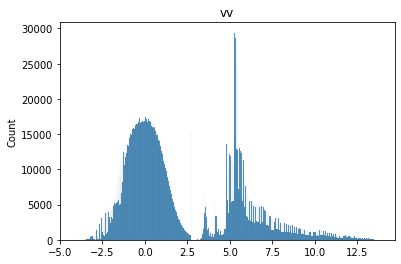

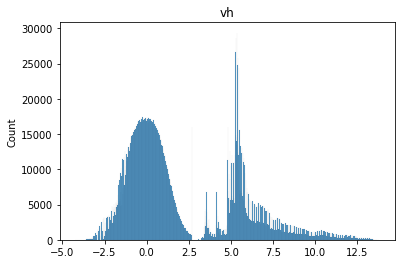

1it [00:52, 52.64s/it]

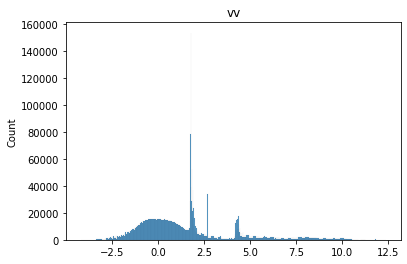

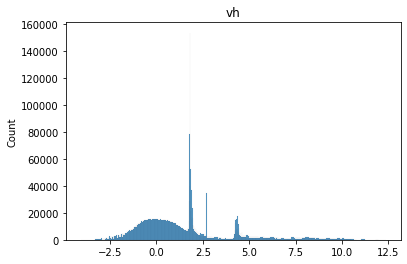

2it [01:14, 34.82s/it]

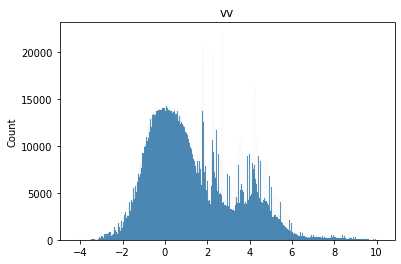

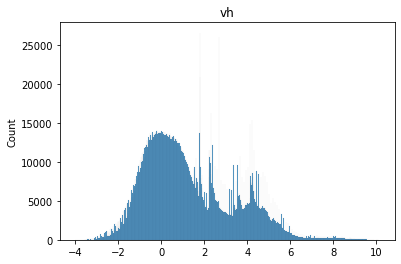

3it [01:27, 24.42s/it]

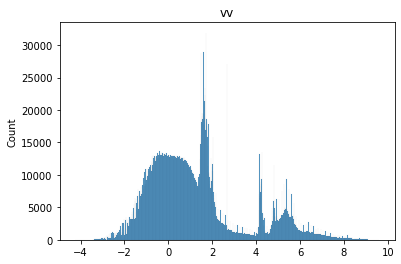

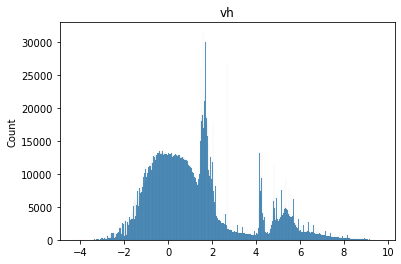

4it [01:35, 18.19s/it]

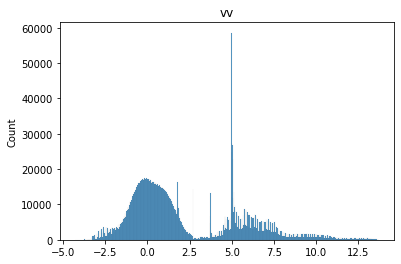

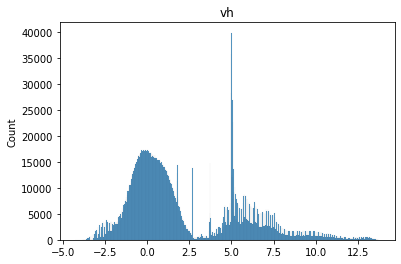

5it [01:43, 20.75s/it]


In [64]:
import seaborn as sns


# compute robust mean and std on data outside (factor x) iqr
for i, (batch, label) in tqdm(enumerate(loader2)):
    if i >= 5:
        break
    batch = batch.numpy()
    batch = batch.reshape(-1, 3)
    valid = label.flatten() != 255
    batch = batch[valid]

    sns.histplot(batch[:, 0].flatten(), bins=1000)
    plt.title("vv")
    plt.show()
    sns.histplot(batch[:, 1].flatten(), bins=1000)
    plt.title("vh")
    plt.show()


In [ ]:
dataset3 = dataset_cls(path=cfg.data_processed, subset="train", include_dem=True, transform=None)
i = dataset3.__getitem__(0)[0]
i.shape

torch.Size([3, 512, 512])